<h1>Analyze COVID-19 data</h1>
In this tutorial, we will use Annotatability to analyze and visualize COVID-19 data using trainability analysis of the disease annotations.

## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from scipy import stats
from Annotatability import models, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
import torch.optim as optim
import scipy.sparse as sp
from numba import jit
from sklearn.preprocessing import normalize
from scipy import stats

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epoch_num=50


In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
sc.set_figure_params(scanpy=True, fontsize=16)
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


<h3>Download the dataset from CELLXGENE</h3>

In [3]:
import scanpy as sc
import requests
from io import BytesIO
# Individual Single-Cell RNA-seq PBMC Data from Arunachalam et al.



url = "https://datasets.cellxgene.cziscience.com/fbe23743-b3b5-4e2c-9bb2-95ee14d36783.h5ad"

# Download the h5ad file
response = requests.get(url)

# Read the downloaded content into a BytesIO object
h5ad_data = BytesIO(response.content)

# Read the h5ad data using read_h5ad function
adata = sc.read_h5ad(h5ad_data)

adata.X = adata.X.toarray()
adata


AnnData object with n_obs × n_vars = 49139 × 22827
    obs: 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'doi', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

<h3> Standard preprocessing</h3>

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
adata = adata[:,adata.var['highly_variable']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


/Users/jonathankarin/.conda/envs/anno_check/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/Users/jonathankarin/.conda/envs/anno_check/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:580: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


<h3> Visualization</h3>

In [5]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


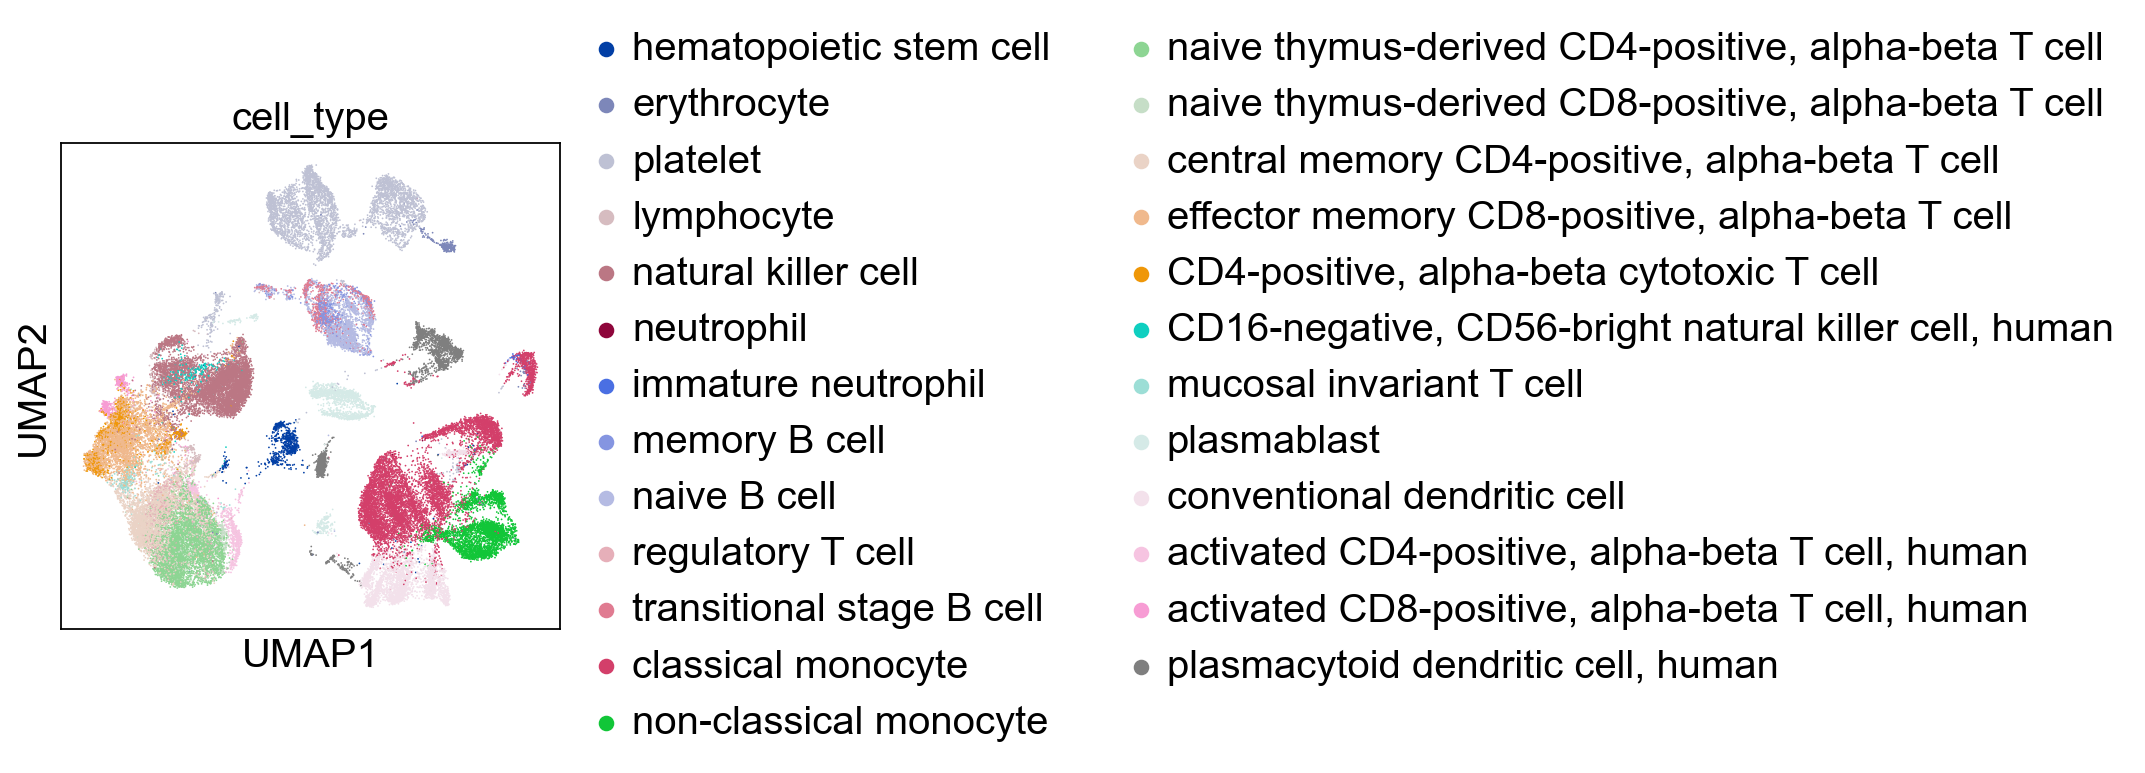

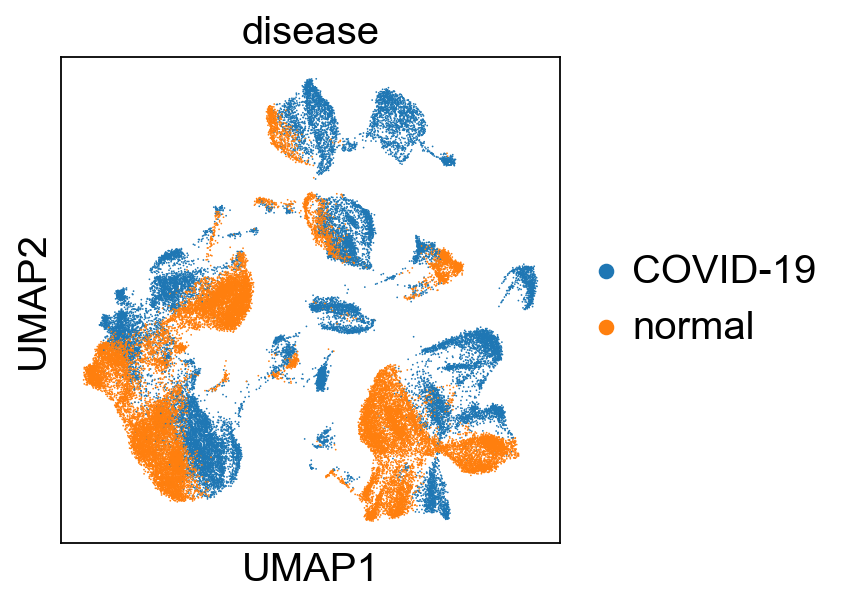

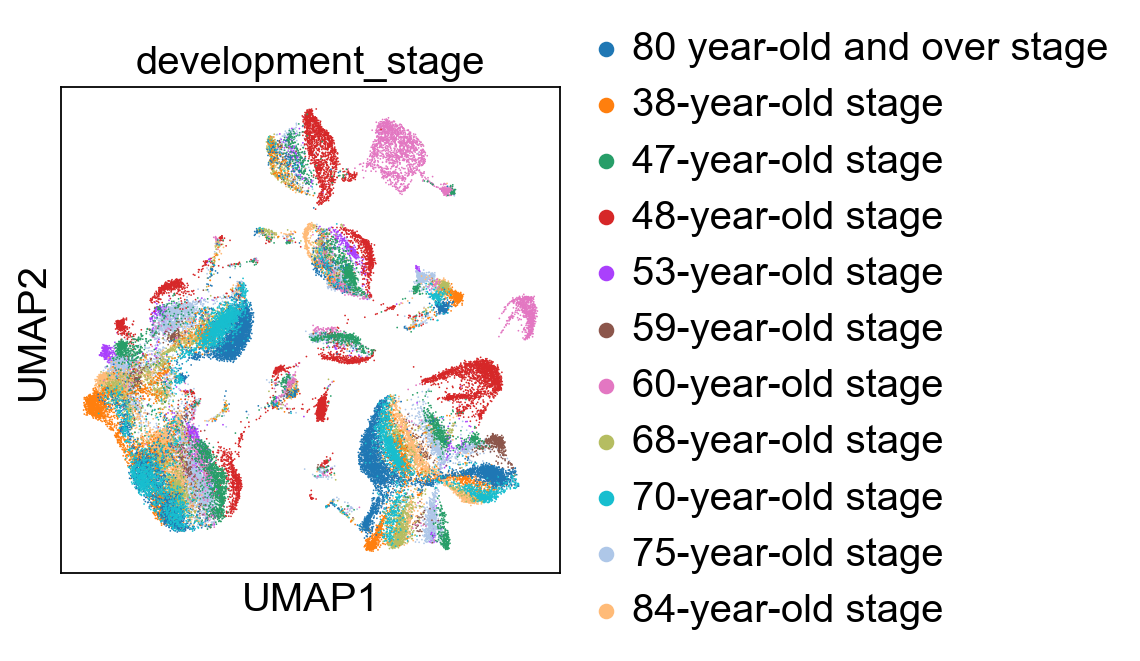

In [6]:
sc.pl.umap(adata,color=['cell_type'])
sc.pl.umap(adata,color=['disease'])
sc.pl.umap(adata,color=['development_stage'])

<h3> Train the neural network and monitor the training dynamics</h3>
Here we will apply Annotatability framework for the disease annotation (normal vs COVID-19). 
You can adjust the following parameters:<br />
"iterNum"- number of epochs.<br />
"lr"=learning rate, default is 0.001 <br />
"momentum"- default is 0.9,<br />
"device"- cuda device, default is 'cpu' <br />
"weighted_sampler"- use weighted sampler or not, default is True<br />
"batch_size"- default is 256

In [7]:
epoch_num=100
prob_list = models.follow_training_dyn_neural_net(adata, label_key='disease',iterNum=epoch_num, device=device)

/Users/jonathankarin/.conda/envs/anno_check/lib/python3.9/site-packages/Annotatability/models.py:328: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs[label_key][i] == t:


[1,     2] loss: 0.139
[1,    12] loss: 0.689
[1,    22] loss: 0.661
[1,    32] loss: 0.628
[1,    42] loss: 0.591
[1,    52] loss: 0.552
[1,    62] loss: 0.514
[1,    72] loss: 0.474
[1,    82] loss: 0.429
[1,    92] loss: 0.384
[1,   102] loss: 0.341
[1,   112] loss: 0.310
[1,   122] loss: 0.274
[1,   132] loss: 0.254
[1,   142] loss: 0.230
[1,   152] loss: 0.206
[1,   162] loss: 0.188
[1,   172] loss: 0.183
[1,   182] loss: 0.161
[1,   192] loss: 0.150
[2,     2] loss: 0.030
[2,    12] loss: 0.133
[2,    22] loss: 0.129
[2,    32] loss: 0.120
[2,    42] loss: 0.117
[2,    52] loss: 0.109
[2,    62] loss: 0.096
[2,    72] loss: 0.093
[2,    82] loss: 0.092
[2,    92] loss: 0.093
[2,   102] loss: 0.083
[2,   112] loss: 0.089
[2,   122] loss: 0.080
[2,   132] loss: 0.088
[2,   142] loss: 0.076
[2,   152] loss: 0.087
[2,   162] loss: 0.071
[2,   172] loss: 0.066
[2,   182] loss: 0.065
[2,   192] loss: 0.062
[3,     2] loss: 0.014
[3,    12] loss: 0.068
[3,    22] loss: 0.066
[3,    32] 

In [8]:
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)

<h4>Visualize the datamap</h4>

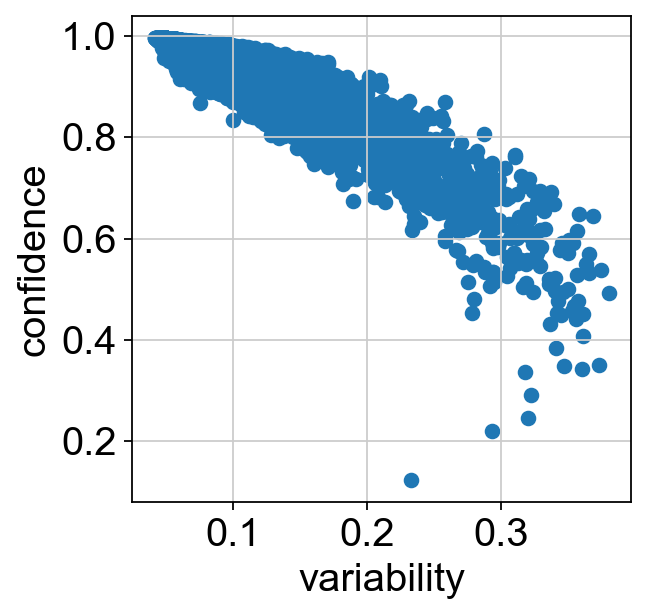

In [9]:
plt.scatter( all_var.detach().numpy(),all_conf.detach().numpy())
plt.xlabel('variability')
plt.ylabel('confidence')
plt.show()


In [10]:
adata.obs["var"] = list(all_var.detach().numpy())
adata.obs["conf"] = list(all_conf.detach().numpy())


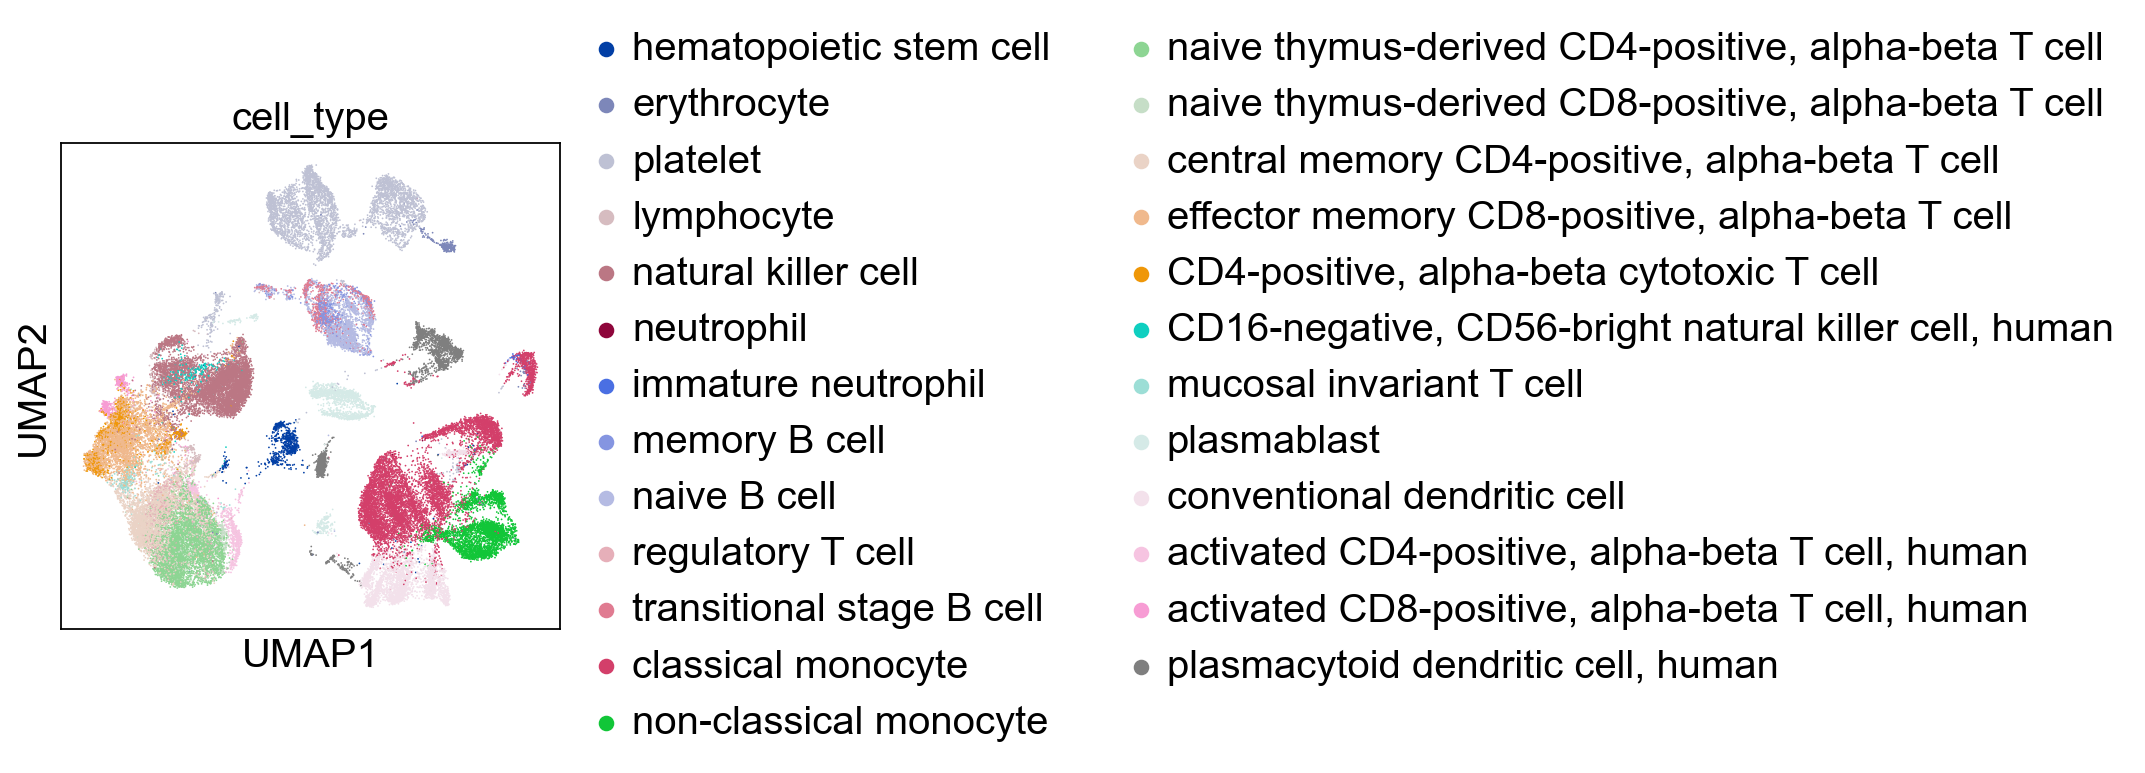

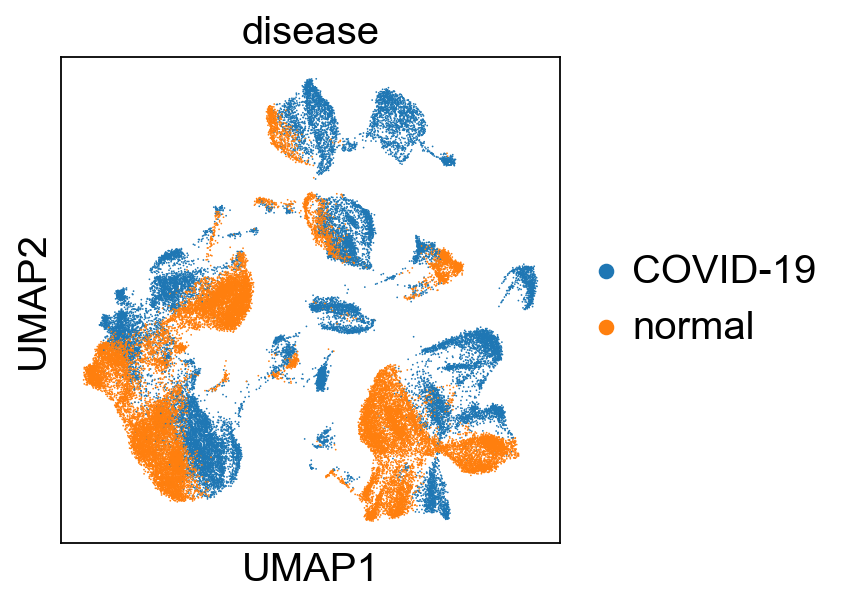

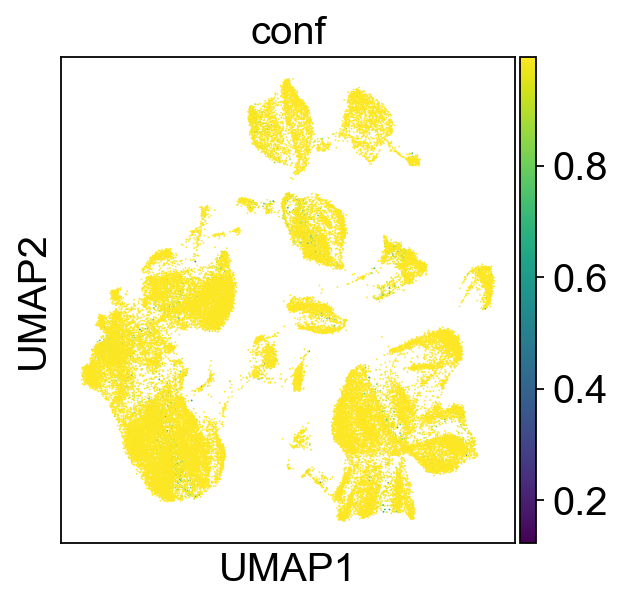

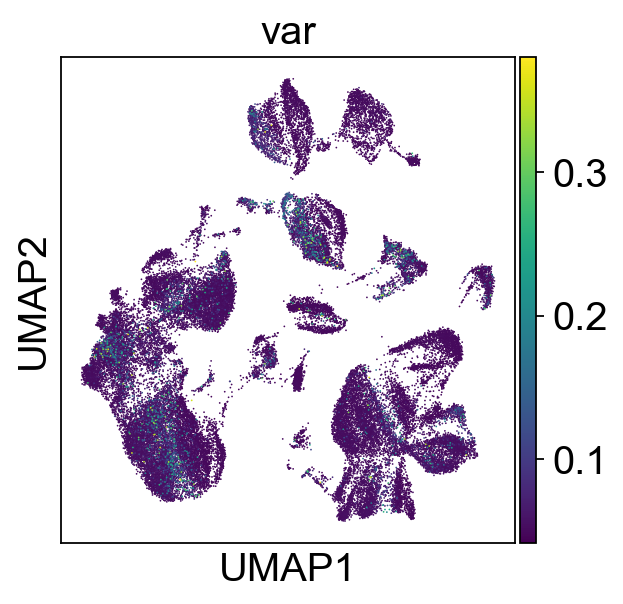

In [11]:
sc.pl.umap(adata,color=['cell_type'])
sc.pl.umap(adata,color=['disease'])
sc.pl.umap(adata,color=['conf'])
sc.pl.umap(adata,color=['var'])


Datamap of each cell type separately.

non-classical monocyte
3359


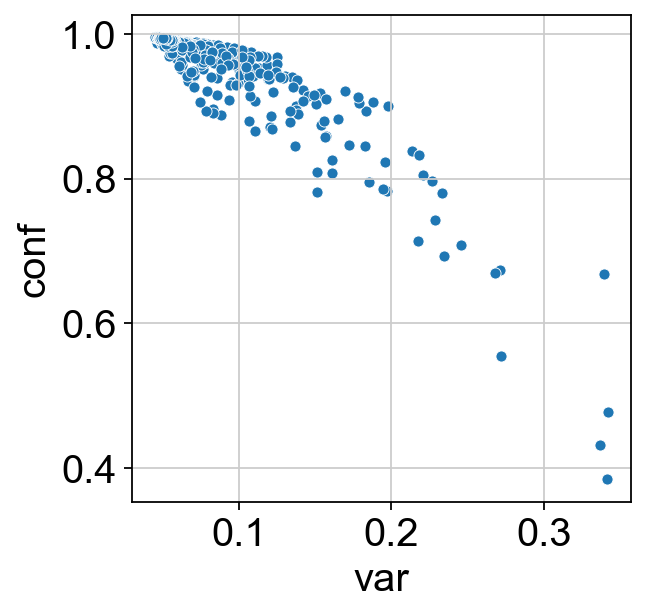

plasmacytoid dendritic cell, human
2128


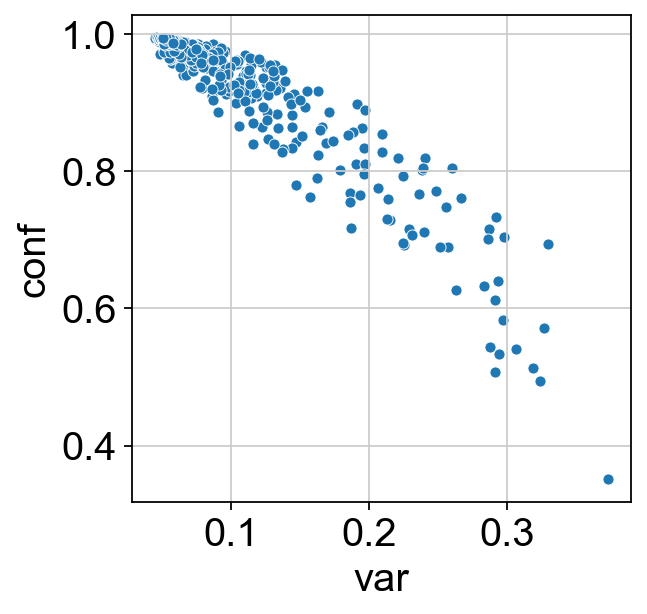

effector memory CD8-positive, alpha-beta T cell
3615


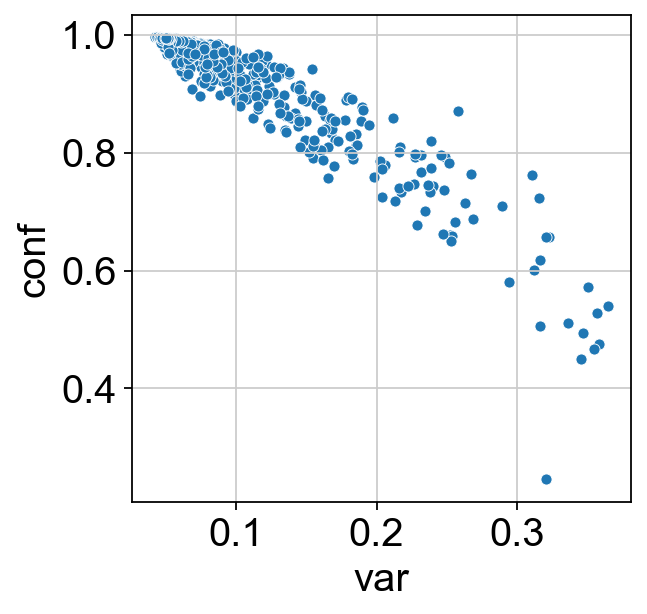

naive thymus-derived CD4-positive, alpha-beta T cell
4919


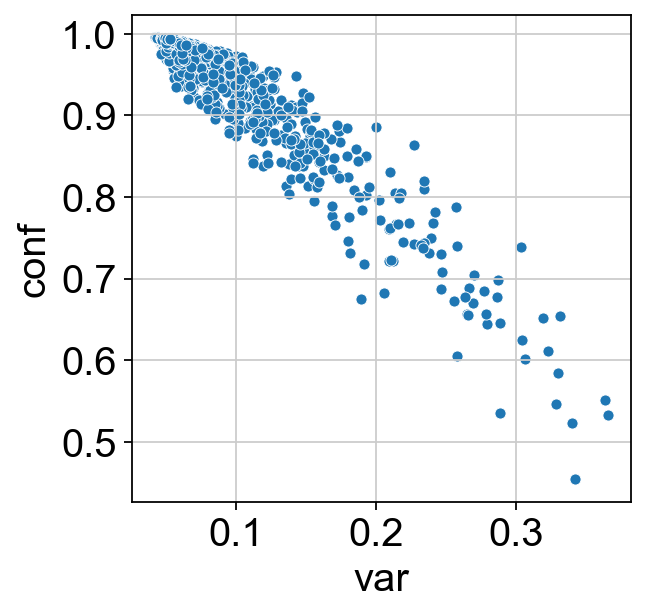

activated CD8-positive, alpha-beta T cell, human
470


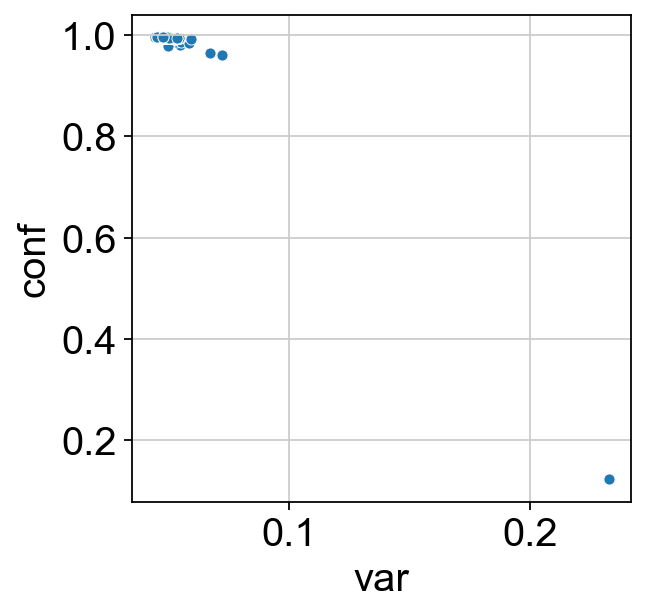

naive B cell
2037


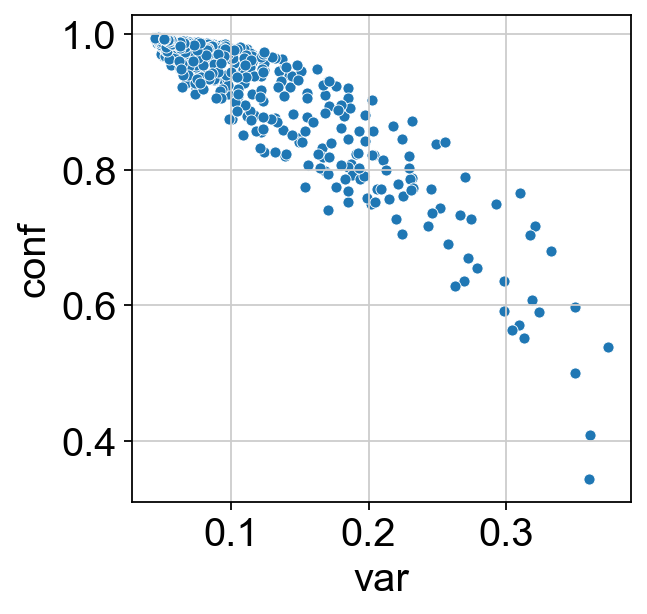

conventional dendritic cell
2966


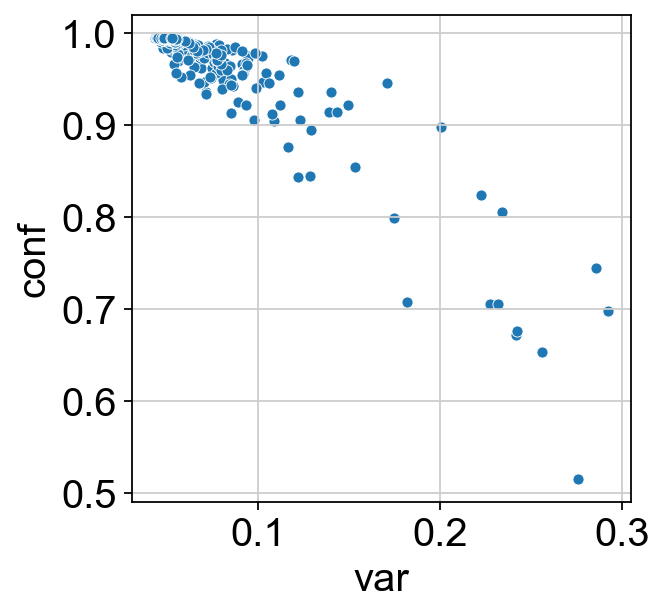

erythrocyte
294


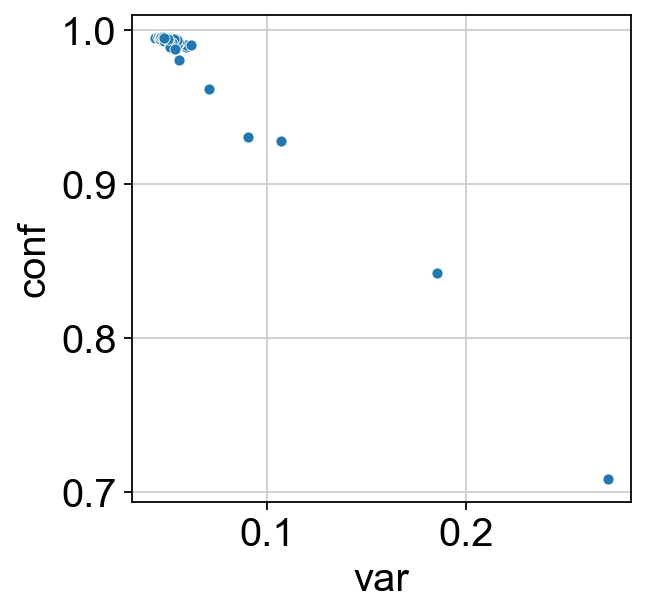

CD16-negative, CD56-bright natural killer cell, human
210


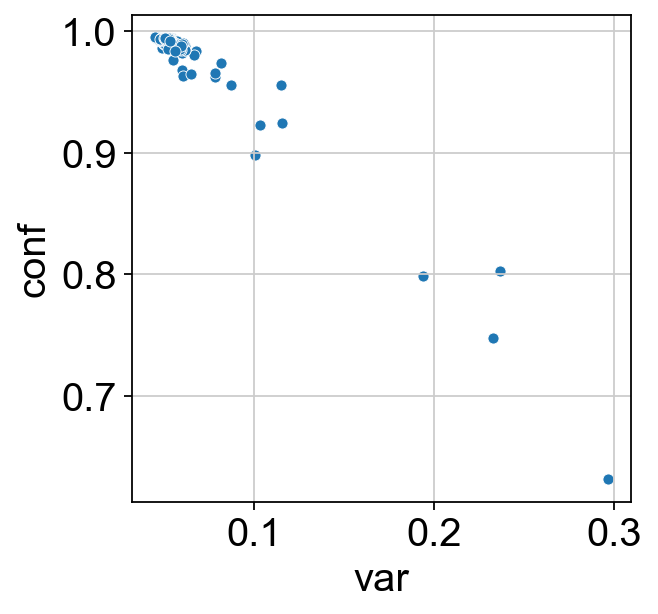

naive thymus-derived CD8-positive, alpha-beta T cell
401


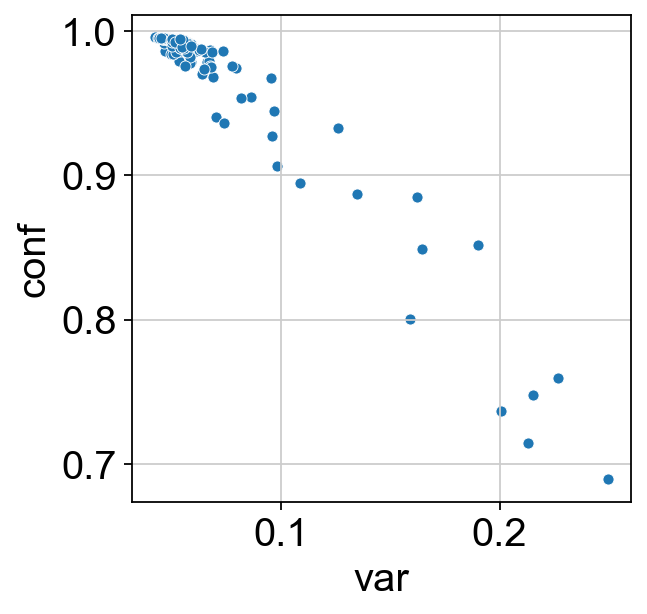

CD4-positive, alpha-beta cytotoxic T cell
1176


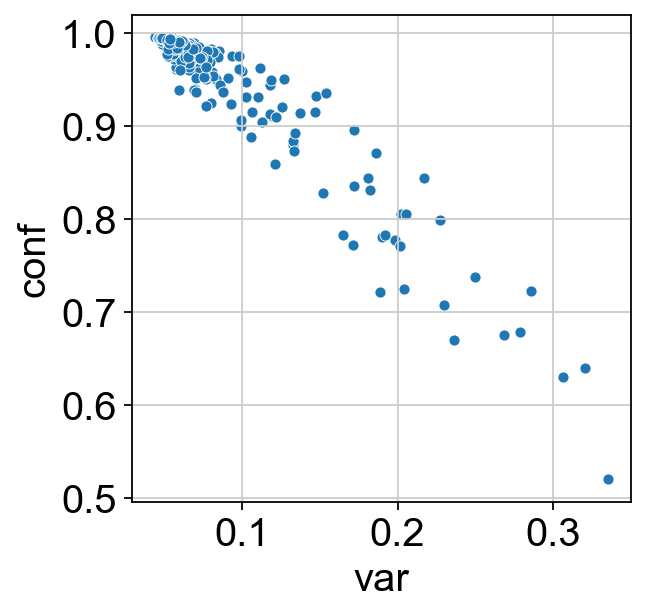

platelet
4348


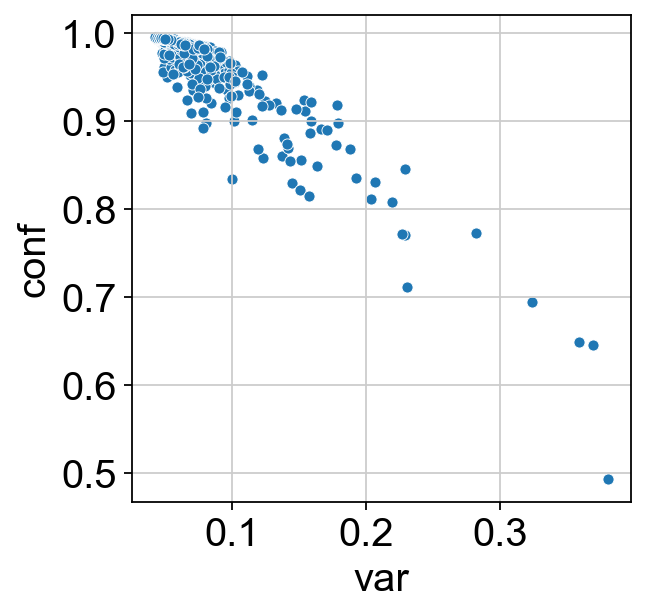

classical monocyte
7915


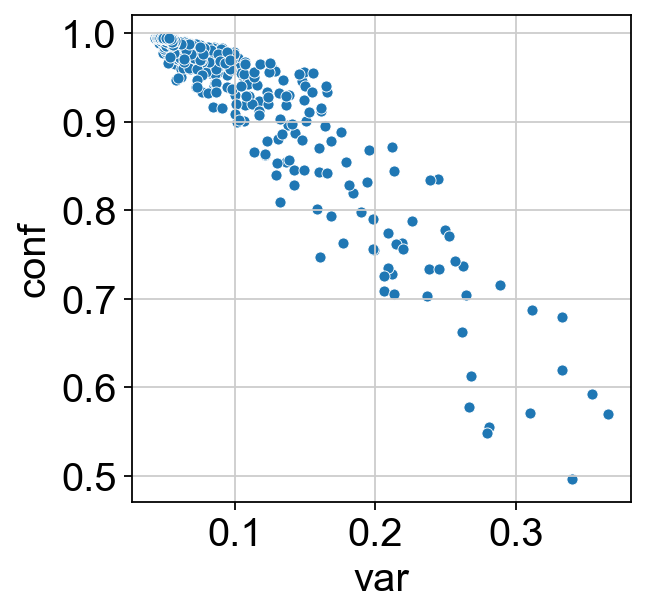

lymphocyte
364


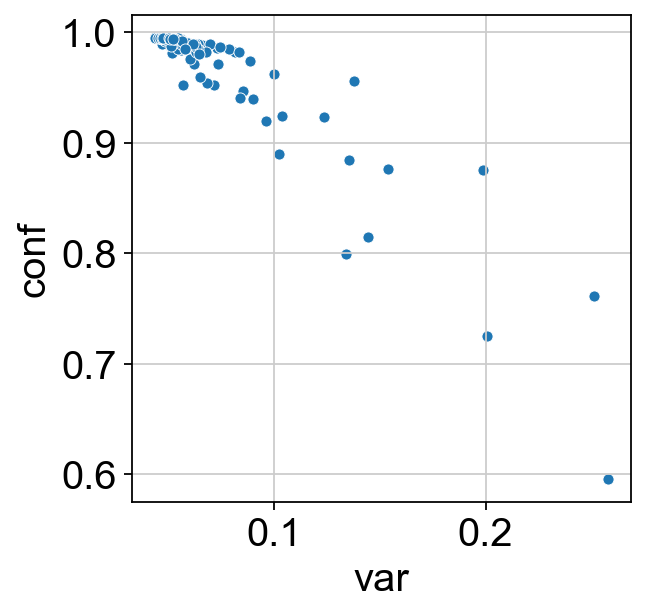

transitional stage B cell
708


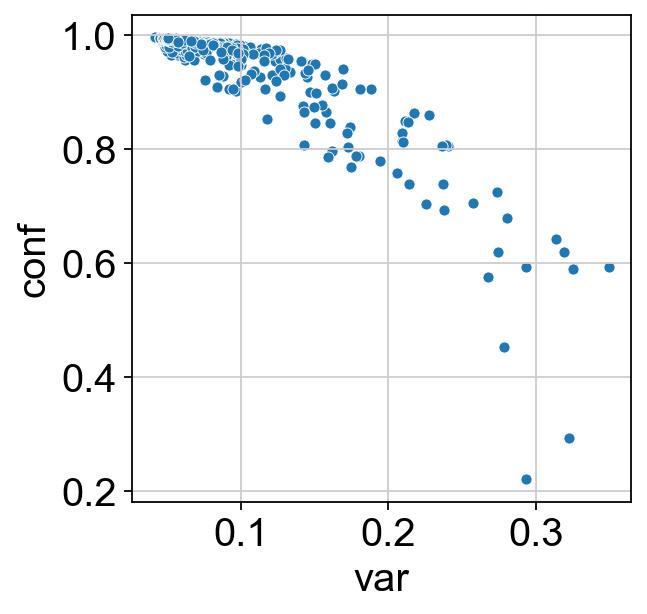

activated CD4-positive, alpha-beta T cell, human
974


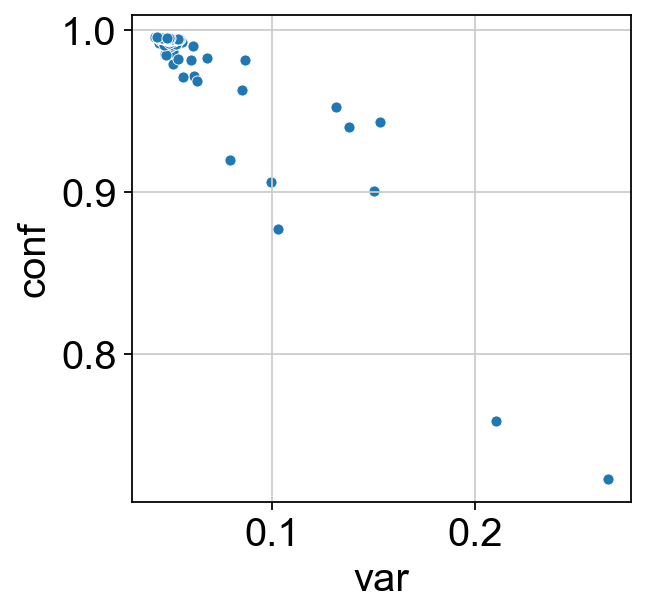

natural killer cell
6332


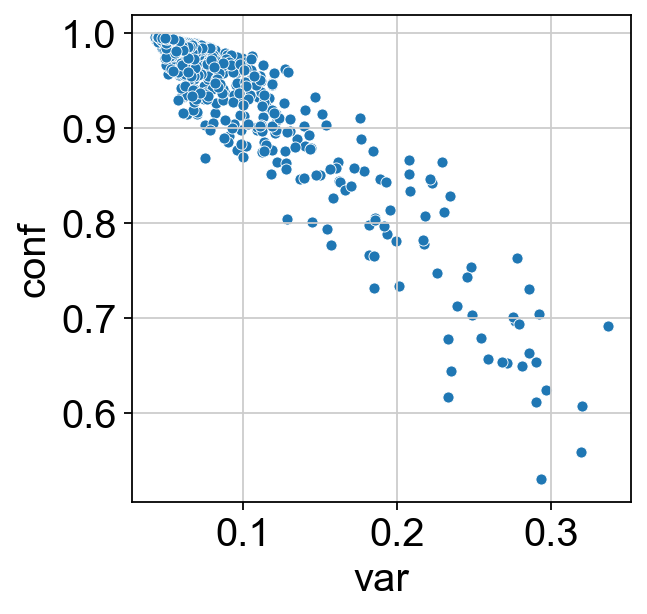

memory B cell
469


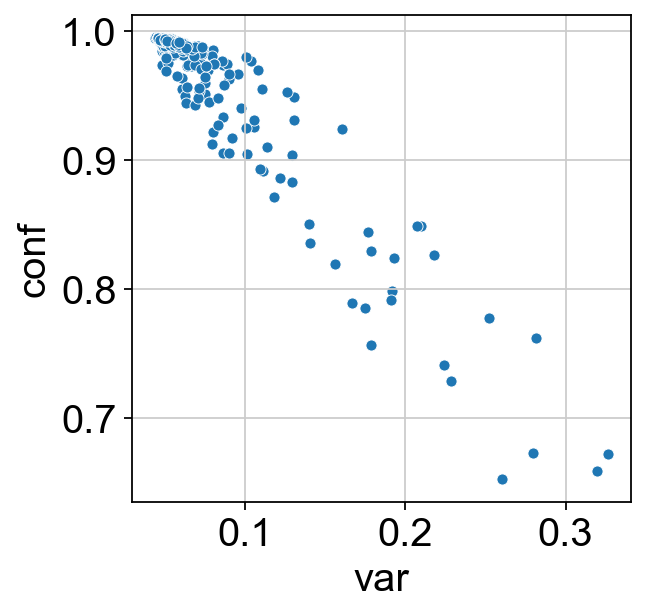

mucosal invariant T cell
215


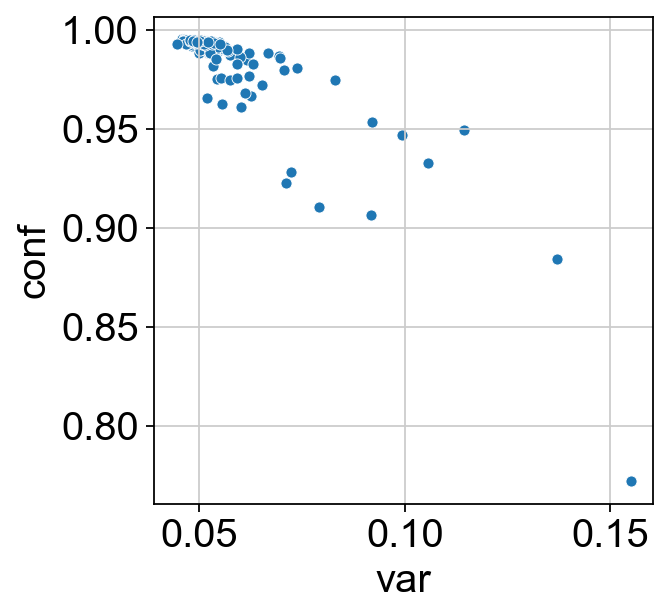

hematopoietic stem cell
703


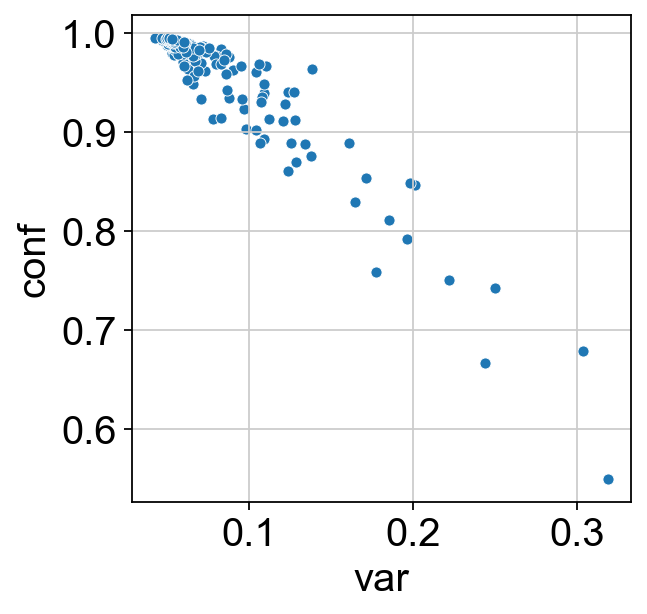

regulatory T cell
570


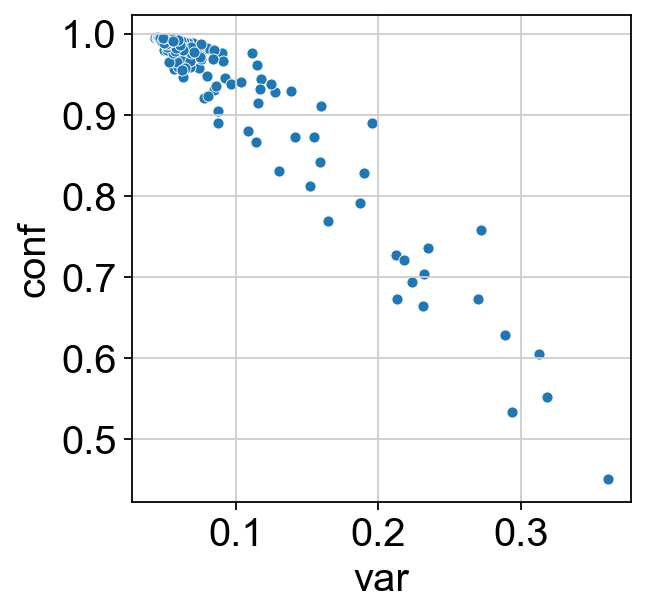

neutrophil
6


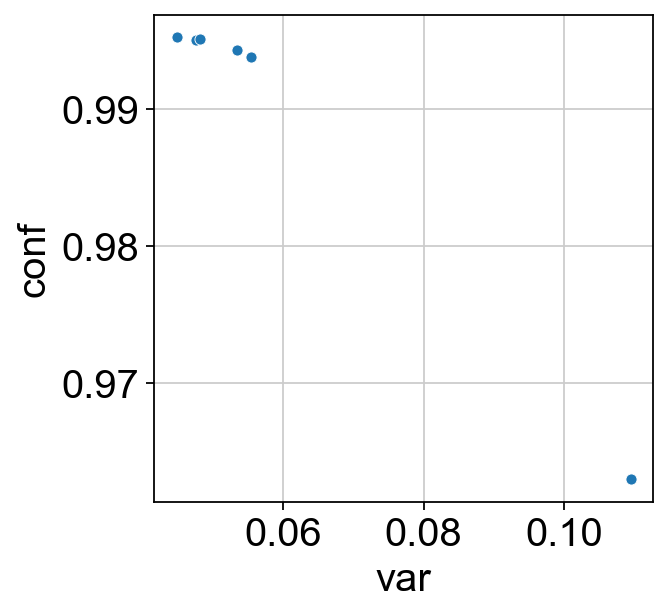

central memory CD4-positive, alpha-beta T cell
3500


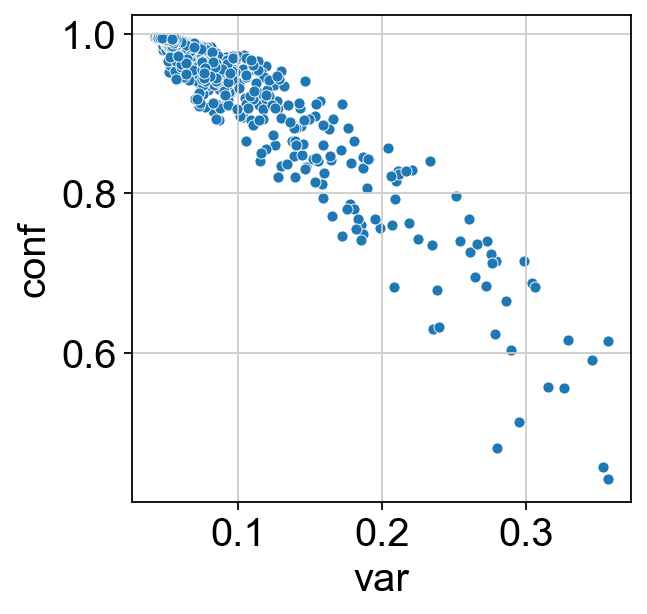

immature neutrophil
40


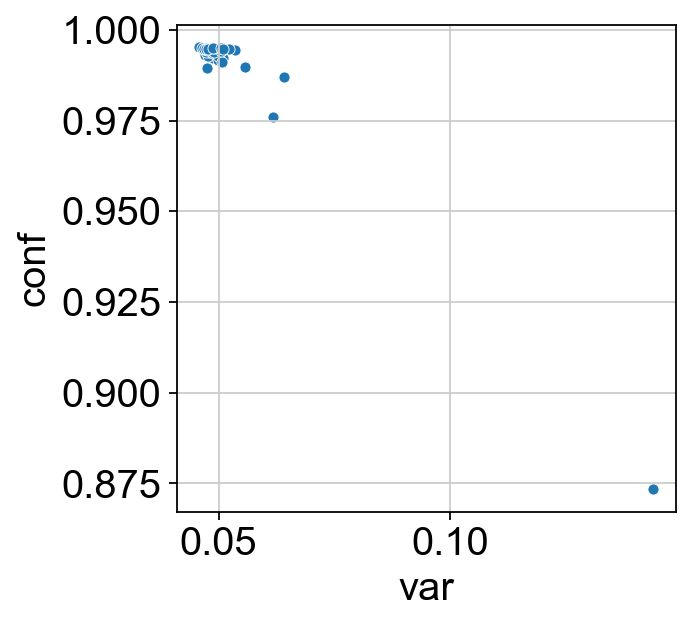

plasmablast
1420


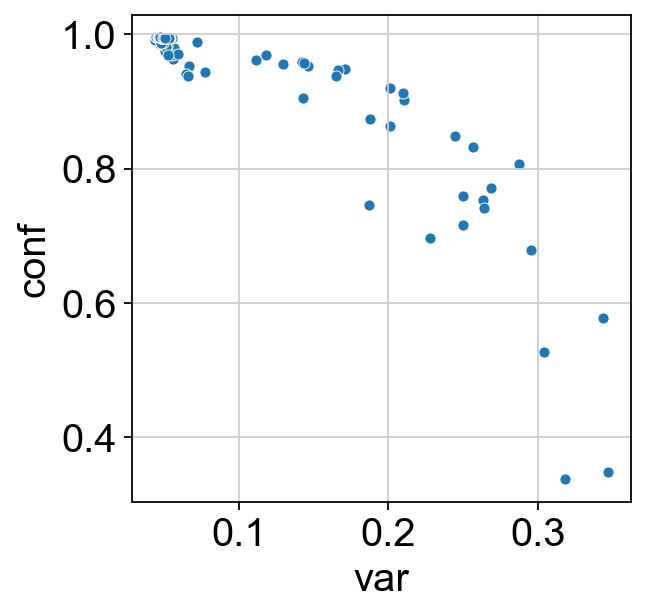

In [12]:
for i in set(list(adata.obs['cell_type'])):
    print(i)
    adata_tmp = adata[adata.obs['cell_type'].isin([i])]
    print(adata_tmp.n_obs)
    fig = sns.scatterplot(data=adata_tmp.obs, x="var", y="conf",s=25)
    plt.show()

In [13]:
adata.obs['Confidence']=adata.obs['conf']
adata.obs['Variability']=adata.obs['var']

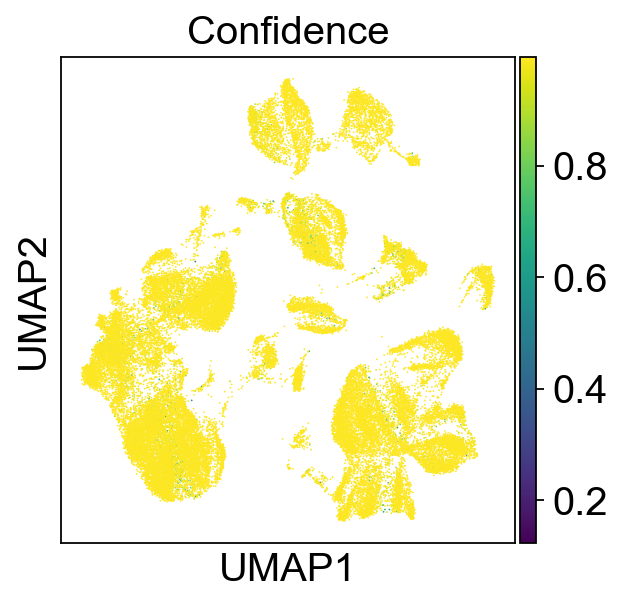

In [14]:
sc.pl.umap(adata,color=['conf'], title='Confidence')


Focusing on the natural killer cells.

In [15]:
adata_nk = adata[adata.obs['cell_type'].isin(['natural killer cell'])]
adata_nk

View of AnnData object with n_obs × n_vars = 6332 × 3000
    obs: 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'var', 'conf', 'Confidence', 'Variability'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'citation', 'doi', 'schema_refere

In [16]:
sc.pp.pca(adata_nk)
sc.pp.neighbors(adata_nk)

/Users/jonathankarin/.conda/envs/anno_check/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/Users/jonathankarin/.conda/envs/anno_check/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [17]:
sc.tl.umap(adata_nk)

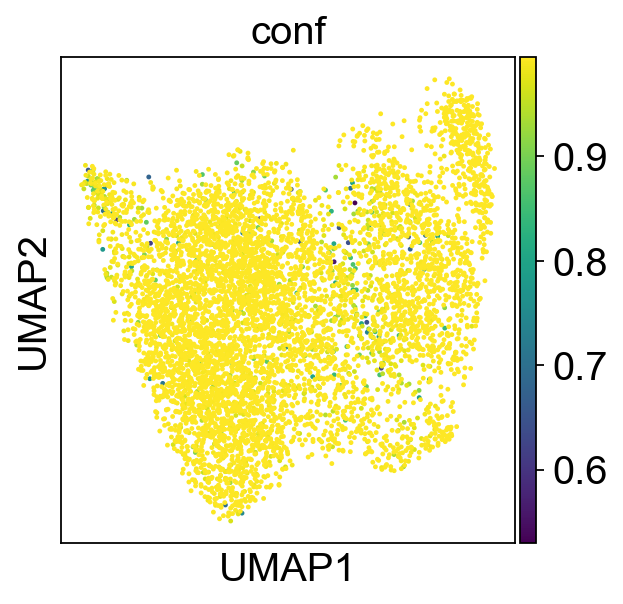

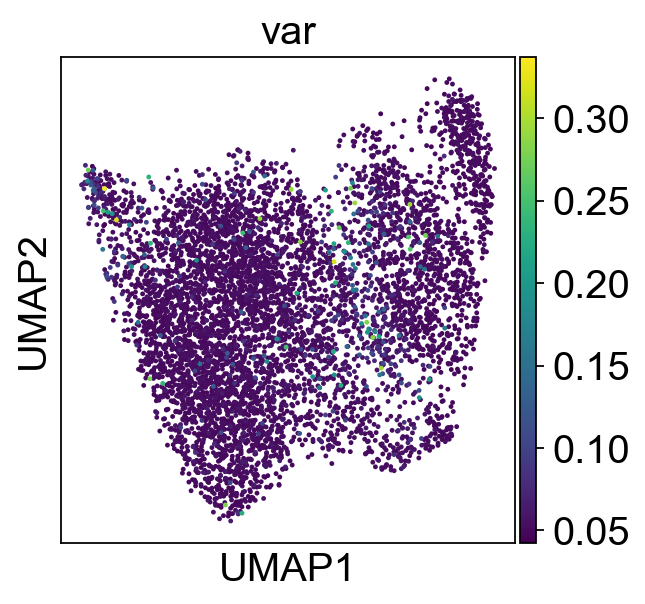

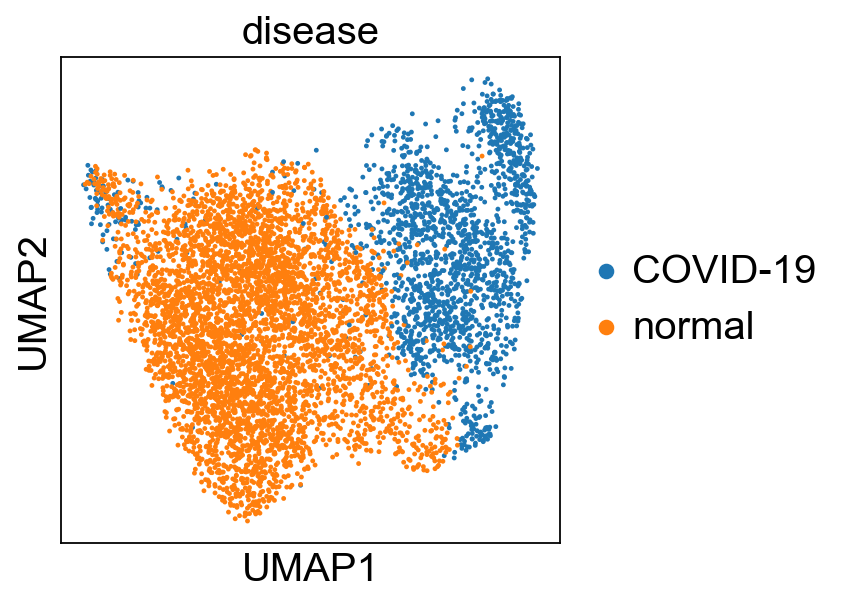

In [18]:
sc.pl.umap(adata_nk, color='conf')
sc.pl.umap(adata_nk, color='var')
sc.pl.umap(adata_nk, color='disease')

<h3> Create the trainability-aware graph-embedding which combines the confidence and the gene expression</h3>
"alpha"- tunable parameter (0 ≤ α ≤ 1), which interpolates between a gene expression-based distance matrix (α=1) and a trainabilitybased distance matrix (α=0).<br />
"k"- amount of neigbors for the KNN graph.

In [19]:
adata_nk_graph = adata_nk.copy()
connectivities_graph , distance_graph  = metrics.make_conf_graph(adata_nk_graph.copy(), alpha=0.9 , k=15)

adata_nk_graph.obsp['connectivities']=sp.csr_matrix(connectivities_graph)

sc.tl.umap(adata_nk_graph)


In [29]:
sc.tl.leiden(adata_nk_graph, resolution=0.3)
sc.tl.leiden(adata_nk, resolution=0.3)

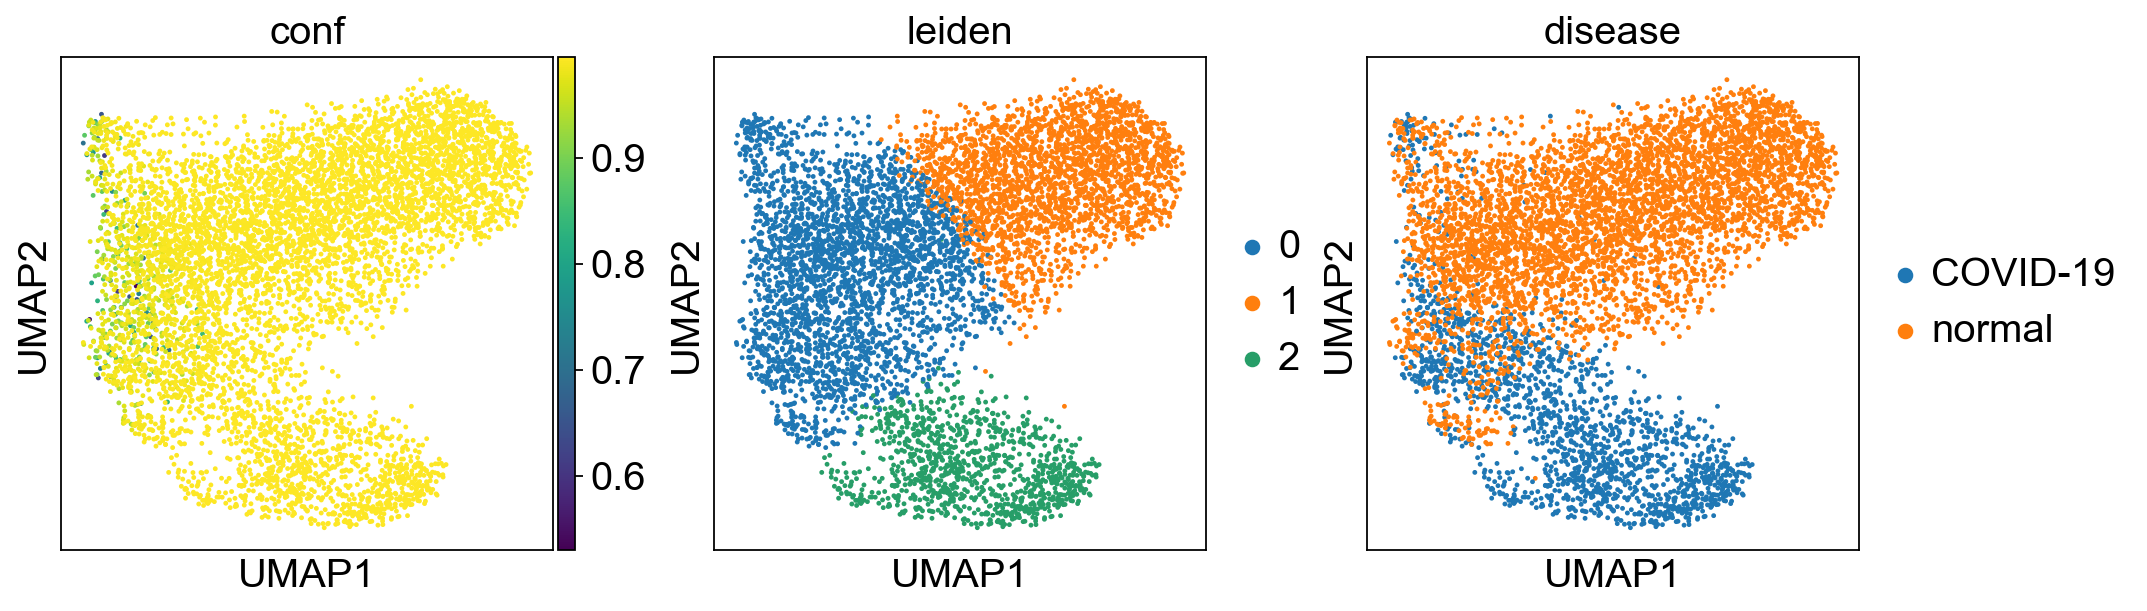

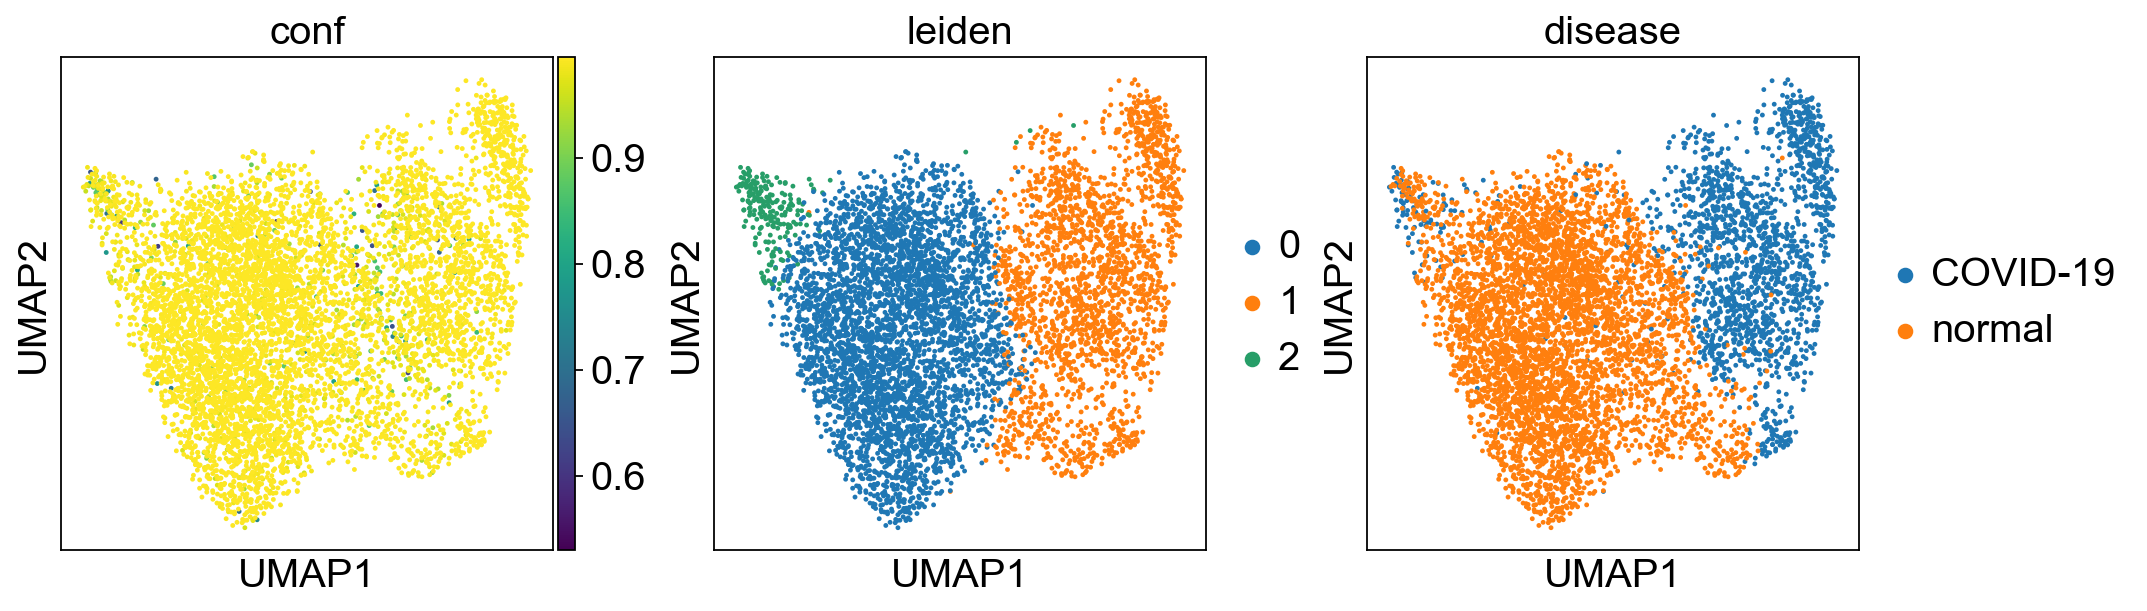

In [30]:
sc.pl.umap(adata_nk_graph, color=['conf','leiden','disease'])
sc.pl.umap(adata_nk, color=['conf','leiden','disease'])

For the trainability-aware graph embedding, we observe three clusters: '0'—a shared cluster containing cells in states common to both the COVID-19 and normal clusters; '1'—cells in states belonging exclusively to the normal cluster; and '2'—cells in states associated with COVID-19.
We can discover state-associated genes with two options, differential expression analysis between the clusters or by using the 'annotation-trainability associated genes' method.

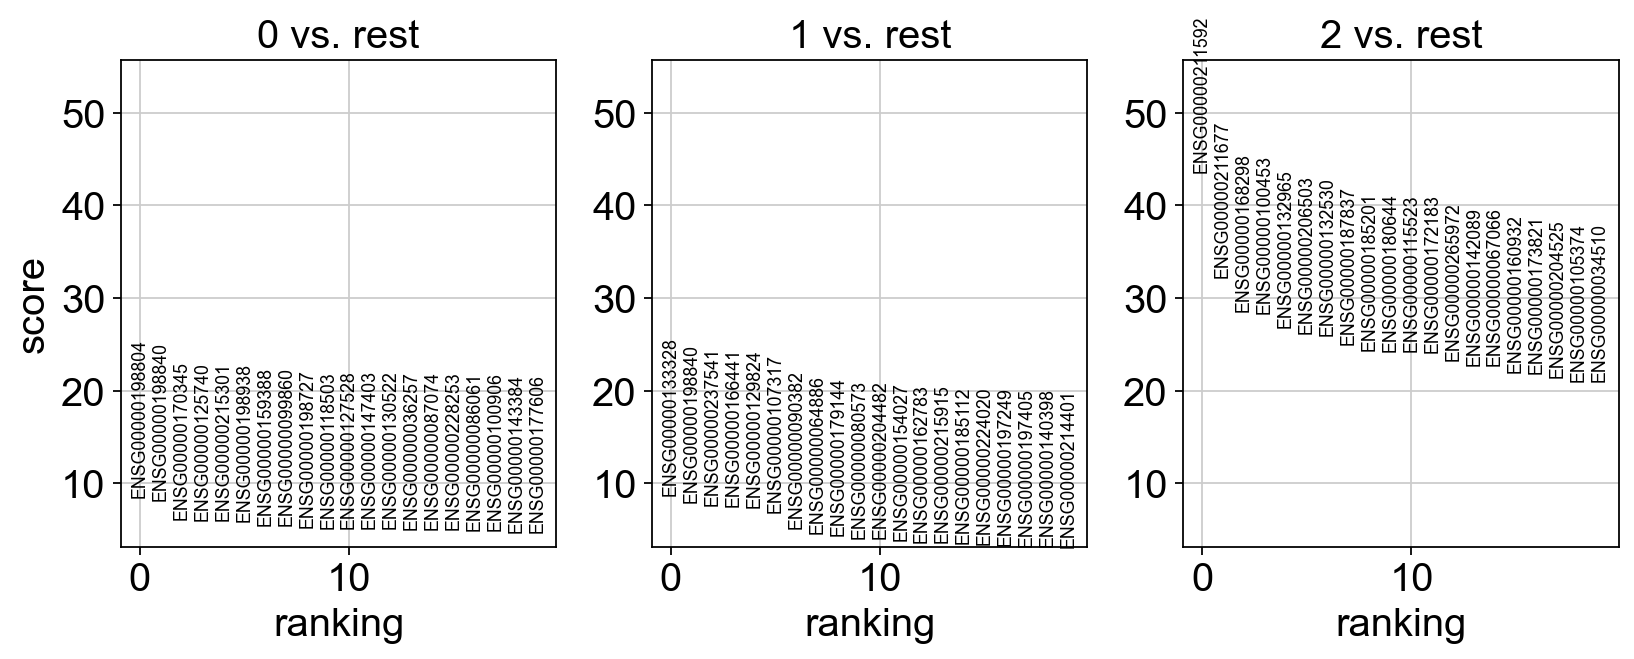

In [31]:
sc.tl.rank_genes_groups(adata_nk_graph,'leiden')
sc.pl.rank_genes_groups(adata_nk_graph)


<h3>Find annotation-trainability associated genes</h3> 
The annotation-trainability positive association score would be stored as adata_bc1ab_ranked.var['conf_score_high'] and the annotation-trainability negative association score would be stored as adata_bc1ab_ranked.var['conf_score_low'].

In [33]:
adata_nk_covid = adata_nk[adata_nk.obs['disease'].isin(['COVID-19'])]
adata_nk_normal = adata_nk[adata_nk.obs['disease'].isin(['normal'])]

In [34]:
adata_nk_covid_ranked = metrics.rank_genes_conf_min_counts(adata_nk_covid, 1,1)
adata_nk_normal_ranked = metrics.rank_genes_conf_min_counts(adata_nk_normal, 1,1)


In [35]:
adata_nk_covid_ranked.var['conf_score_low'].sort_values(ascending=False).index[:10]

Index(['ENSG00000251562', 'ENSG00000108107', 'ENSG00000105374',
       'ENSG00000034510', 'ENSG00000108298', 'ENSG00000112306',
       'ENSG00000142676', 'ENSG00000198502', 'ENSG00000156508',
       'ENSG00000156482'],
      dtype='object')

In [36]:
adata_nk_covid_ranked.var['conf_score_high'].sort_values(ascending=False).index[:10]

Index(['ENSG00000211592', 'ENSG00000211677', 'ENSG00000211895',
       'ENSG00000211679', 'ENSG00000132465', 'ENSG00000142089',
       'ENSG00000187837', 'ENSG00000160932', 'ENSG00000157601',
       'ENSG00000132530'],
      dtype='object')